Author: Alonso Menéndez González

This notebook contains the code necessary to prepare the datasets and manage the model, comprising the First and Second step in the Fault Detection System. Specifically, this code was made for the XJTU-SY dataset, but with minor adjustments, it could be reused for any dataset.

First, the dataset is loaded and the model is defined in a Class, which will be later extended to include the training loop. Afterwards, it is trained using the selected dataset's healthy samples, process monitorized by using wandb. Finally, after the model has finished learning from the healthy distributions, it is asked to predict the mean and variances of the whole dataset, which are saved for the next step in the Fault Detection System.

**Please note:** This code was written as a Google Colab Notebook that uses Weights & Biases. Therefore, several changes must be made before executing it.

**Table of contents**<a id='toc0_'></a>    
- [Imports and installations](#toc1_1_)    
- [Dataset](#toc2_)    
  - [Getting a sample](#toc2_1_)    
- [Model Definition](#toc3_)    
  - [Encoder](#toc3_1_)    
    - [Test](#toc3_1_1_)    
  - [Decoder](#toc3_2_)    
    - [Test](#toc3_2_1_)    
  - [LogLikelihood](#toc3_3_)    
    - [Test](#toc3_3_1_)    
  - [VAE class](#toc3_4_)    
    - [Test](#toc3_4_1_)    
  - [Training Loop](#toc3_5_)    
- [Train Model](#toc4_)    
- [Test model](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Imports and installations](#toc0_)
Packages, libraries and Wandb key setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
!pip install wandb


In [ ]:
!pip install torch

In [ ]:
import wandb
import os
from google.colab import userdata
import pandas as pd
import numpy as np
import glob

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim

import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
wandb_key = userdata.get('wandb')

In [ ]:
wandb.login(key=wandb_key)

# <a id='toc2_'></a>[Dataset](#toc0_)
Preparation of the CustomDataset class

In [ ]:
# These are just the names of the experiments
condition = "40Hz10kN" #"37.5Hz11kN" # "40Hz10kN"
bearing = "Bearing3_4" #"Bearing2_1" #"Bearing2_3" "Bearing3_1" "Bearing3_4"

In [ ]:
csv_directory = "/content/drive/MyDrive/TFM/XJTU-SY_Bearing_Datasets/" + condition +"/"+ bearing

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, folder_path, partitions=1,top=300):
      """
      folder_path: Path to the folder containing the dataset. Expects to find several csv files in it. 
      partitions: if each file is too big (memory limitations), consider increasing this number to split them into smaller chunks. Default 1.
      top: number of files to consider as healthy (only get the top n files). Default 300.
      """
      self.folder_path = folder_path
      self.file_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)][:top]
      self.partitions = partitions

    def __len__(self):
        return len(self.file_paths) * self.partitions

    def __getitem__(self, index):
        file_index = index // self.partitions
        part_index = index % self.partitions

        file_path = self.file_paths[file_index]
        df = pd.read_csv(file_path,sep=",")#, header=None)
        chunks = np.array_split(df, self.partitions)
        data = chunks[part_index]
        tensor = torch.Tensor(data.values)
        tensor = torch.flatten(tensor)
        return tensor

In [ ]:
dataset = CustomDataset(folder_path=csv_directory) # As top is 300, this is the "training dataset"

In [ ]:
len(dataset) # Should be the same as "top"

300

In [ ]:
batch_size = 8 # Careful with big datasets and memory available

In [ ]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## <a id='toc2_1_'></a>[Getting a sample](#toc0_)

In [ ]:
train = iter(dataloader)

In [ ]:
i = next(train)

In [ ]:
i.shape

torch.Size([8, 65536])

In [ ]:
input_size = i.shape[1]

# <a id='toc3_'></a>[Model Definition](#toc0_)
Contains all the necessary classes to build the VAE_extended class. Each section contains small tests that were used during development.

## <a id='toc3_1_'></a>[Encoder](#toc0_)

In [ ]:
class encoder(nn.Module):

    def __init__(self, dimz, input_size):


        super().__init__()

        self.dimz = dimz    #dimz is k, the dimension of the latent space

        self.linear1 = nn.Linear(input_size, 3500)
        self.linear2 = nn.Linear(3500, 700)
        self.linear3 = nn.Linear(700, 200)
        self.linear4 = nn.Linear(200,10)
        self.linear5 = nn.Linear(10,dimz*2)

        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()



    def forward(self,x):

        z = torch.flatten(x, start_dim=1)

        z = self.relu(self.linear1(z))
        z = self.relu(self.linear2(z))
        z = self.relu(self.linear3(z))
        z = self.relu(self.linear4(z))



        z = self.linear5(z)

        return z

    def encode_and_sample(self,x,flag_sample=True):

        # This methods compute both the posterior mean and variance
        # Also we obtain a sample from the posterior using the
        # reparameterization trick.

        # We obtain the encoder projection using the forward method

        z = self.forward(x)

        # The mean is the first dimz components of the forward output

        #mu = torch.clamp(z[:,:self.dimz], min=0.0) # Monotonic
        mu = z[:,:self.dimz]

        # We compute the variance from the last dimz components using a
        # soft plus
        var = self.softplus(0.5 * z[:, self.dimz:])

        sample = None

        if(flag_sample==True):

            eps = torch.randn_like(var)

            sample = mu + eps*(var**0.5)

        return mu,var,sample

### <a id='toc3_1_1_'></a>[Test](#toc0_)

In [ ]:
#enc = encoder(dimz=2,input_size=input_size)
#mu_z, var_z, sample = enc.encode_and_sample(x=i)

In [ ]:
#mu_z

## <a id='toc3_2_'></a>[Decoder](#toc0_)

In [ ]:
class decoder(nn.Module):

    def __init__(self, dimz, output_size):


        super().__init__()

        self.dimz = dimz    #dimz is k, the dimension of the latent space

        self.linear1 = nn.Linear(dimz,10)
        self.linear2 = nn.Linear(10,200)
        self.linear3 = nn.Linear(200,700)
        self.linear4 = nn.Linear(700,3500)
        self.linear5 = nn.Linear(3500,output_size)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()



    def forward(self,z):

        z = self.relu(self.linear1(z))
        z = self.relu(self.linear2(z))
        z = self.relu(self.linear3(z))
        z = self.relu(self.linear4(z))
        x = self.tanh(self.linear5(z))

        return x

    def decode(self,z):

        return self.forward(z)

### <a id='toc3_2_1_'></a>[Test](#toc0_)

In [ ]:
#dec = decoder(dimz=2,output_size=input_size)
#x_mean = dec.decode(mu_z).detach()

In [ ]:
#x_mean.shape

In [ ]:
#x_mean.reshape(batch_size,-1)

## <a id='toc3_3_'></a>[LogLikelihood](#toc0_)

In [ ]:
def eval_Gaussian_LL(x,mu_x,var_x):

    # x is a mini-batch of data. It has dimension [Batch,n_recordings,n_sensors]

    # mu_x is a mini-batch of reconstructed images. It has dimension [Batch,n_recordings,n_sensors]

    # var_x is a torch constant

    D = x.shape[1] # Dimension of the image

    x = x.reshape(-1, D)

    mu_x = mu_x.reshape(-1, D)

    var_x = torch.ones_like(mu_x) * var_x

    # Constant term in the gaussian distribution
    cnt = D * np.log(2 * np.pi) + torch.sum(torch.log(var_x), dim=-1)

    # log-likelihood per datapoint

    logp_data = -0.5 * (cnt + torch.sum((x - mu_x) * var_x ** -1 * (x - mu_x), dim=-1))

    # Accumulated Gaussian log-likelihood for all datapoints in the batch
    logp = torch.sum(logp_data)

    return logp,logp_data

### <a id='toc3_3_1_'></a>[Test](#toc0_)

In [ ]:
#var_x = 0.1
#
#logp,logp_data = eval_Gaussian_LL(i,x_mean,var_x)
#
#print(logp)
#
#plt.plot(np.arange(0,batch_size),logp_data)

## <a id='toc3_4_'></a>[VAE class](#toc0_)

In [ ]:
class VAE(nn.Module):

    def __init__(self,dimz,input_size,var_x=0.1):

        super().__init__()

        self.var_x = var_x

        self.dimz = dimz
        self.input_size = input_size

        # We create an encoder network

        self.encoder = encoder(self.dimz, self.input_size)

        # We create a decoder network

        self.decoder = decoder(self.dimz, self.input_size)

    def forward(self,x):

        # In the forward method, we return the mean and variance
        # given by the encoder network and also the reconstruction mean
        # given by the decoder network using a sample from the
        # encoder's posterior distribution.

        mu_z,var_z,sample_z = self.encoder.encode_and_sample(x=x)

        # Decoder provides the mean of the reconstruction

        mu_x = self.decoder.decode(sample_z)

        return mu_x,mu_z,var_z

    # Reconstruction + KL divergence losses summed over all elements and batch

    def loss_function(self, x, mu_x, mu_z, var_z):

        # We evaluate the loglikelihood in the batch using the function provided above

        logp,_ = eval_Gaussian_LL(x, mu_x, torch.tensor(0.1))

        # KL divergence between q(z) and N()
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114

        KLz = -0.5 * torch.sum(1 + torch.log(var_z) - mu_z.pow(2) - var_z)

        # To maximize ELBO we minimize loss (-ELBO)
        return -logp + KLz, -logp, KLz

### <a id='toc3_4_1_'></a>[Test](#toc0_)

In [ ]:
#my_vae = VAE(dimz=2,input_size=input_size)

In [ ]:
#print(my_vae.loss_function(i,x_mean,mu_z,var_z))

## <a id='toc3_5_'></a>[Training Loop](#toc0_)

In [ ]:
class VAE_extended(VAE):

    def __init__(self,name,notes,
                 dimz=2,  input_size=3, var_x=0.1,lr=1e-3,epochs=20,
                 save_folder='/content/drive/MyDrive/TFM/models/',restore=False,
                 ):

        super().__init__(dimz,input_size=input_size,var_x=var_x)

        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs

        self.save_folder = save_folder
        self.name = name

        if(restore==True):
            state_dict = torch.load(self.save_folder+self.name+'.pth')
            self.load_state_dict(state_dict)

        self.loss_during_training = []
        self.reconstruc_during_training = []
        self.KL_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)



        wandb.init(
          project="TFM",
          entity="healthcare-ai",
          name=name,
          notes=notes,
          config={
            "epochs": epochs,
            "layer_size": [input_size, 4000, 1000, 200, 50, dimz],
            "lr": lr,
            "var_x": var_x,
            })

    def trainloop(self,trainloader):

        nims = len(trainloader.dataset)

        self.train()

        for e in range(int(self.epochs)):

            train_loss = 0
            train_rec = 0
            train_kl_l = 0

            idx_batch = 0

            for items in trainloader:

                items = items.to(self.device)

                self.optim.zero_grad()

                mu_x, mu_z, var_z = self.forward(items)

                loss, rec, kl_l = self.loss_function(items,mu_x, mu_z, var_z)

                loss.backward()

                train_loss += loss.item()
                train_rec += rec.item()
                train_kl_l += kl_l.item()

                self.optim.step()

                if (idx_batch % (len(trainloader)//20) == 0):

                  print(f'Training: {idx_batch}/{len(trainloader)}')

                if(idx_batch%10==0):

                    torch.save(self.state_dict(), self.save_folder + self.name +'.pth')
                    #print(f'Train Batch: {idx_batch}')

                idx_batch += 1


            self.loss_during_training.append(train_loss/len(trainloader))
            self.reconstruc_during_training.append(train_rec/len(trainloader))
            self.KL_during_training.append(train_kl_l/len(trainloader))

            metrics = {"train/train_loss": train_loss/len(trainloader),
                       "train/train_reconstruction": train_rec/len(trainloader),
                       "train/train_kl_loss": train_kl_l/len(trainloader),
                       "train/epoch": e,
                       }

            wandb.log(metrics)

            if(e%1==0):

                torch.save(self.state_dict(), self.save_folder + self.name +'.pth')
                print('Train Epoch: {} \tLoss: {:.6f}'.format(e,self.loss_during_training[-1]))


    def sample(self,num_imgs):

        with torch.no_grad():

            eps = torch.randn([num_imgs,self.dimz]).to(self.device)

            x_sample = self.decoder.decode(eps)

            return x_sample.to("cpu").detach()

    def encode_and_sample_loop(self, dataloader, flag_sample=True):
      """


      parameters:
        dataloader: of a dataset. Careful with batch size.
        flag_sample: if true, a sample with mu and var will be computed.


      For each of the elements of dataloader, encode and obtain the following:
        mu_x: mean of the element, of size (batch_size, dimz)
        var_x: variance, same size
        sample: using the previous values, adquire a sample.
      """
      for items in dataloader:
        items = items.to(self.device)
        mu_x, var_x, sample = self.encoder.encode_and_sample(x=items,flag_sample=flag_sample)

        for row_index in range(mu_x.shape[0]):
          mu = mu_x[row_index].tolist()
          var = var_x[row_index].tolist()




          wandb.log({"mu0":mu[0],
                     #"mu1":mu[1],
                     #"mu2":mu[2],
                     #"mu3":mu[3],
                     #"mu4":mu[4],
                     "var0":var[0],
                     #"var1":var[1],
                     #"var2":var[2],
                     #"var3":var[3],
                     #"var4":var[4],
                     })






# <a id='toc4_'></a>[Train Model](#toc0_)
Code for training the model. First the class is initialized and the trainloop is executed afterwards.

In [ ]:
my_vae_scratch = VAE_extended(name="VAE-XJTU-3-4-First",
                              notes="First attempt, using 300 healthy, same arquitecture as with IMS. 2nd part",
                              dimz=1, epochs=20, lr=1e-5,
                              input_size=input_size, restore=True)

In [ ]:
my_vae_scratch.trainloop(dataloader)

Training: 0/38
Training: 1/38
Training: 2/38
Training: 3/38
Training: 4/38
Training: 5/38
Training: 6/38
Training: 7/38
Training: 8/38
Training: 9/38
Training: 10/38
Training: 11/38
Training: 12/38
Training: 13/38
Training: 14/38
Training: 15/38
Training: 16/38
Training: 17/38
Training: 18/38
Training: 19/38
Training: 20/38
Training: 21/38
Training: 22/38
Training: 23/38
Training: 24/38
Training: 25/38
Training: 26/38
Training: 27/38
Training: 28/38
Training: 29/38
Training: 30/38
Training: 31/38
Training: 32/38
Training: 33/38
Training: 34/38
Training: 35/38
Training: 36/38
Training: 37/38
Train Epoch: 0 	Loss: 587760.733553
Training: 0/38
Training: 1/38
Training: 2/38
Training: 3/38
Training: 4/38
Training: 5/38
Training: 6/38
Training: 7/38
Training: 8/38
Training: 9/38
Training: 10/38
Training: 11/38
Training: 12/38
Training: 13/38
Training: 14/38
Training: 15/38
Training: 16/38
Training: 17/38
Training: 18/38
Training: 19/38
Training: 20/38
Training: 21/38
Training: 22/38
Training

In [ ]:
for i in train_dataloader:
  print(i)
  break

tensor([[[-0.1030, -0.0200,  0.0240,  ..., -0.1880, -0.2860, -0.1070],
         [-0.0680, -0.0680, -0.0150,  ..., -0.0070, -0.1760, -0.2590],
         [-0.0590,  0.1290, -0.0630,  ..., -0.0390, -0.1270, -0.2120],
         ...,
         [-0.1440, -0.1490, -0.1590,  ..., -0.0880, -0.1050, -0.2250],
         [-0.1540, -0.0780, -0.0610,  ..., -0.0930, -0.0490, -0.1710],
         [-0.0950, -0.0320, -0.2100,  ..., -0.3520, -0.1610, -0.1200]]])


# <a id='toc5_'></a>[Test model](#toc0_)

In [ ]:
dataset = CustomDataset(folder_path=csv_directory, top=-1)

In [ ]:
len(dataset)

1514

In [ ]:
dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

In [ ]:
dataloader = iter(dataloader)

In [ ]:
len(dataloader)

190

In [ ]:
my_vae_scratch = VAE_extended(name="VAE-XJTU-2-3-First",
                              notes="Drawing histograms",
                              dimz=1, epochs=0, lr=1e-5,
                              input_size=input_size, restore=True)

In [ ]:
# If the following block fails, uncomment this line and try again
# my_vae_scratch.encode_and_sample_loop(dataloader=dataloader,flag_sample=False)

In [ ]:
res = pd.DataFrame(columns=["mu_x","var_x"])

for items in dataloader:
        items = items.to(my_vae_scratch.device)
        mu_x, var_x, sample = my_vae_scratch.encoder.encode_and_sample(x=items)
        df = pd.DataFrame({
            'mu_x': sum(mu_x.tolist(), []),
            'var_x': sum(var_x.tolist(), []),
        })

        res = pd.concat([res,df], ignore_index=True)


In [ ]:
res

,mu_x,var_x
0,6.131987,0.001321
1,-4.529427,0.000942
2,6.898650,0.000658
3,9.259309,0.000408
4,-3.499679,0.001598
...,...,...
2532,1.411085,0.022051
2533,-0.290470,0.012026
2534,3.984034,0.008962
2535,6.151705,0.002184


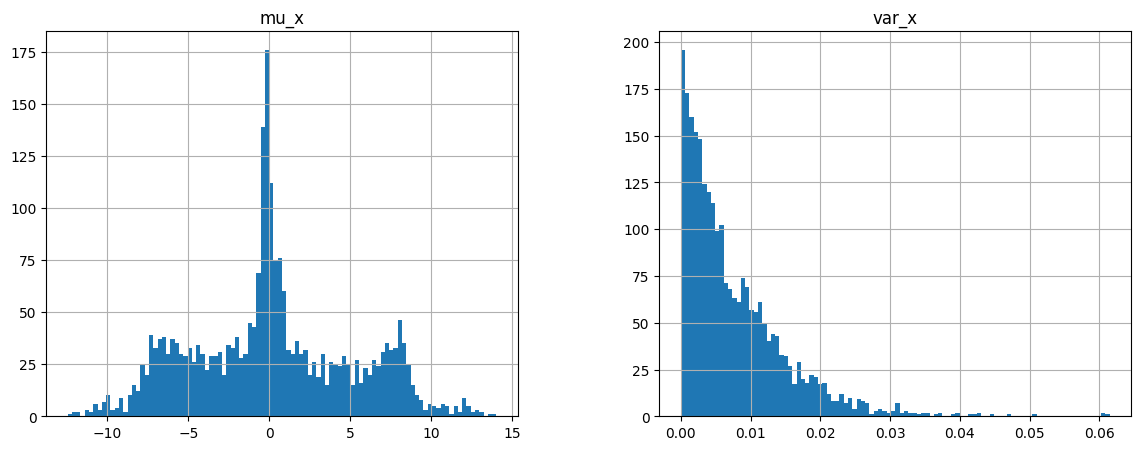

In [ ]:
res.hist(bins=100, figsize=(14, 5))  # Adjust the number of bins and figure size as needed
plt.show()

In [ ]:
res.to_csv("/content/drive/MyDrive/TFM/MeanVars/XJTU-3-1-mean-var.csv")